# Abalone dataset - linear regression

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel

from src.machinery.GradientDescent import ArtemisDescent, FL_VanillaSGD
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import KIND_COMPRESSION

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "superconduct"

nb_devices_for_the_run = 10
MAX_NB_DEVICES = 10

In [2]:
import pandas as pd
data = pd.read_csv('../dataset/superconduct/train.csv', sep=",")
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [3]:
data.describe()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
count,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,...,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000
mean,4.115224,87.557631,72.988310,71.290627,58.539916,1.165608,1.063884,115.601251,33.225218,44.391893,...,3.153127,3.056536,3.055885,1.295682,1.052841,2.041010,1.483007,0.839342,0.673987,34.421219
std,1.439295,29.676497,33.490406,31.030272,36.651067,0.364930,0.401423,54.626887,26.967752,20.035430,...,1.191249,1.046257,1.174815,0.393155,0.380291,1.242345,0.978176,0.484676,0.455580,34.254362
min,1.000000,6.941000,6.423452,5.320573,1.960849,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000210
25%,3.000000,72.458076,52.143839,58.041225,35.248990,0.966676,0.775363,78.512902,16.824174,32.890369,...,2.116732,2.279705,2.091251,1.060857,0.775678,1.000000,0.921454,0.451754,0.306892,5.365000
50%,4.000000,84.922750,60.696571,66.361592,39.918385,1.199541,1.146783,122.906070,26.636008,45.123500,...,2.618182,2.615321,2.434057,1.368922,1.166532,2.000000,1.063077,0.800000,0.500000,20.000000
75%,5.000000,100.404410,86.103540,78.116681,73.113234,1.444537,1.359418,154.119320,38.356908,59.322812,...,4.026201,3.727919,3.914868,1.589027,1.330801,3.000000,1.918400,1.200000,1.020436,63.000000
max,9.000000,208.980400,208.980400,208.980400,208.980400,1.983797,1.958203,207.972460,205.589910,101.019700,...,7.000000,7.000000,7.000000,2.141963,1.949739,6.000000,6.992200,3.000000,3.000000,185.000000


In [4]:
if data.isnull().values.any():
    print("There is missing value.")
else:
    print("No missing value. Great !")

No missing value. Great !


In [6]:
X_data = data.loc[:, data.columns != "critical_temp"]
Y_data = data.loc[:, data.columns == "critical_temp"]
dim_notebook = len(X_data.columns)
print("There is " + str(dim_notebook) + " dimensions.")

There is 81 dimensions.


In [7]:
#Data normalisation
X_data=(X_data-X_data.mean())/X_data.std()
X_data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence
0,-0.080056,0.046732,-0.451640,-0.158846,-0.611805,0.044357,-0.003707,0.133722,-0.053037,0.378177,...,-0.907733,-0.752138,-0.805893,-0.711688,0.186288,0.035182,-0.837939,-0.406157,-0.838353,-0.520057
1,0.614729,0.174265,-0.432061,0.059367,-0.604166,0.777412,-0.015267,0.133722,0.108898,0.134898,...,-1.147057,-0.752138,-1.116705,-0.719437,0.664955,-0.014779,-0.033010,-0.362343,-0.426856,-0.450811
2,-0.080056,0.046732,-0.450967,-0.158846,-0.611644,0.044357,-0.218978,0.133722,0.093292,0.378177,...,-0.907733,-0.740146,-0.805893,-0.700712,0.186288,-0.062233,-0.837939,-0.376948,-0.838353,-0.503292
3,-0.080056,0.046732,-0.451304,-0.158846,-0.611724,0.044357,-0.103613,0.133722,0.020127,0.378177,...,-0.907733,-0.746142,-0.805893,-0.706208,0.186288,-0.010537,-0.837939,-0.391552,-0.838353,-0.511512
4,-0.080056,0.046732,-0.452314,-0.158846,-0.611966,0.044357,0.162771,0.133722,-0.199367,0.378177,...,-0.907733,-0.764131,-0.805893,-0.722601,0.186288,0.113625,-0.837939,-0.435366,-0.838353,-0.538165


# Without log of temperatures

In [8]:
print(Y_data.size)
Y_data.head()

21263


,critical_temp
0,29.0
1,26.0
2,19.0
3,22.0
4,23.0


In [9]:
X_merged = torch.tensor(X_data.values, dtype=torch.float64)
Y_merged = torch.tensor(Y_data.values, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)
X, Y = [], []

for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")
X = add_bias_term(X)
print(X[0].shape)
pickle_saver((X, Y), filename + "-data")

Number of points by devices:  2126
There is 10 devices.
torch.Size([2126, 82])


In [10]:
%%time
obj_min_by_N = {}
for nb_devices in tqdm([10]):
    obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                     nb_devices=nb_devices,
                                                     nb_epoch=20000, 
                                                     quantization_param=0,
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_model=RMSEModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
    obj_min_by_N_descent.set_data(X[:nb_devices],Y[:nb_devices])
    obj_min_by_N_descent.run()
    obj_min_by_N[nb_devices] = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-obj_min")

  0%|          | 0/1 [00:00<?, ?it/s]

Large dimension...
   it    |   obj   
    4000 | 3.4234e+02
    8000 | 3.3356e+02
   12000 | 3.2848e+02
   16000 | 3.2504e+02


100%|██████████| 1/1 [01:58<00:00, 118.77s/it]

Gradient Descent: execution time=118.755 seconds
Final loss :  322.53994064331056

CPU times: user 7min 50s, sys: 2.87 s, total: 7min 53s
Wall time: 1min 58s


In [51]:
%%time
all_descent = {}
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, myX, myY, model = RMSEModel(), 
                                               use_averaging=True, nb_epoch=100, stochastic=True)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

  0%|          | 0/3 [00:00<?, ?it/s]

SGD
Large dimension...
Large dimension...


 33%|███▎      | 1/3 [03:27<06:55, 207.62s/it]

Diana
Large dimension...
Large dimension...


 67%|██████▋   | 2/3 [12:22<05:05, 305.66s/it]

Artemis
Large dimension...
Large dimension...


100%|██████████| 3/3 [21:40<00:00, 433.44s/it]

CPU times: user 25min 14s, sys: 2.85 s, total: 25min 17s
Wall time: 21min 40s


In [52]:
print("SGD model, first value corresponds to the bias: ")
print(res.all_final_model[0])

SGD model, first value corresponds to the bias: 
tensor([ 33.9303,  -6.2480,  11.0719,  -7.3567,  -2.6528,   0.6049, -13.7204,
          3.5076,  11.1986,   0.6030,  -6.4043,  -4.5802,   3.4665,   3.3615,
         -2.0618,  -1.3477,   2.3899,  10.6783,  19.7096,   3.7176, -15.3980,
         -5.3139,  11.2054,  21.7627, -19.0934, -14.3926,  -1.2764,  11.2385,
         17.0417,  -3.4227, -23.4353,   9.8328, -11.7888,  -3.0213,   2.1436,
         10.7732,   4.8250,  -6.0300,  -7.3275,   0.3503,  10.2538,  -2.9485,
         -3.0048,  18.1716,   5.4247, -19.4716,   0.5293,  -5.4221, -20.9791,
         -4.2810,  25.7193, -10.2140,   5.7781,  -5.8696,  -4.4990,   2.9225,
         -4.0011,   8.3413,  -7.6548,   4.4057,   3.6841,  -1.5230,  -0.4710,
         20.8368,  -3.4212,  -9.3966,   1.9391,   2.6455, -12.3610,  -8.4875,
         10.6014,   4.8789,  -2.4463,  -0.5419,   5.4184,  -4.2064,  12.9594,
        -18.5323,   6.1064,   2.0604,   0.1661,  -7.9063], dtype=torch.float64)


Text(0, 0.5, 'true value')

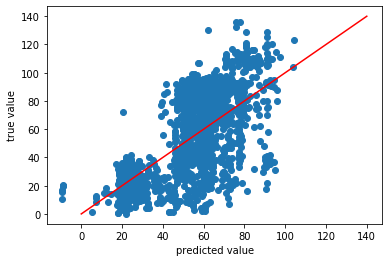

In [53]:
plt.scatter(X[0].mv(res.all_final_model[0]), Y[0])
plt.plot(np.linspace(0, 140, 50), np.linspace(0, 140, 50), color='r')
plt.xlabel("predicted value")
plt.ylabel("true value")

## With averaging

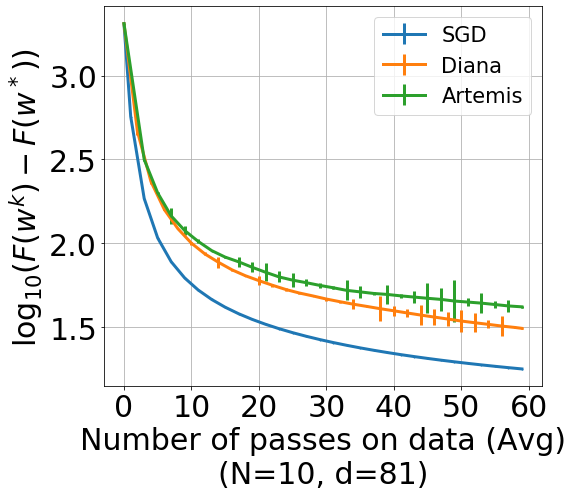

In [54]:
(X,Y) = pickle_loader(filename + "-data")
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), x_legend="Number of passes on data (Avg)") 

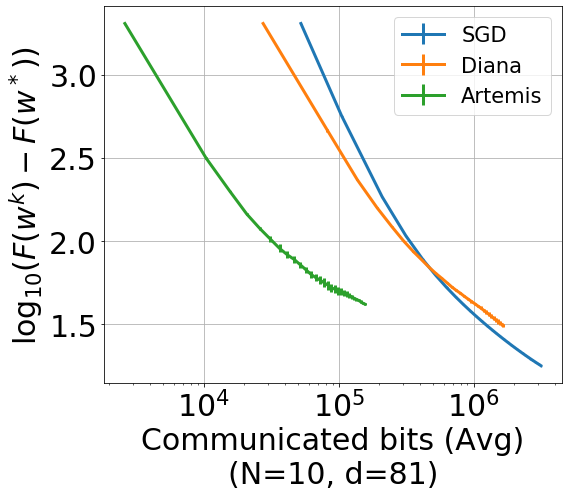

In [55]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


## Without averaging

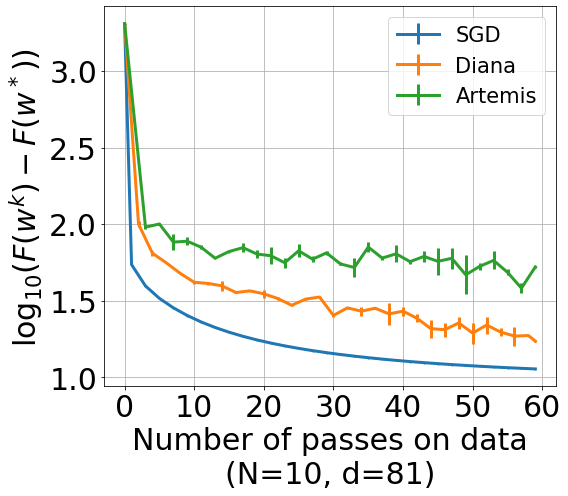

In [56]:
(X,Y) = pickle_loader(filename + "-data")
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 

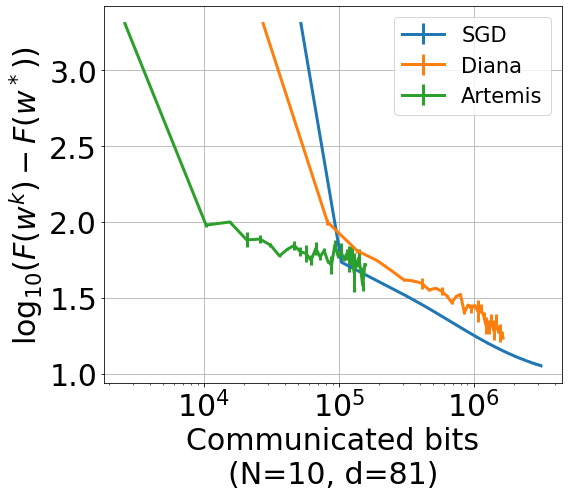

In [57]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 

# Taking log of temperatures

In [8]:
print(Y_data.size)
Y_data['critical_temp'] = np.log(Y_data['critical_temp'])
Y_data.head()

21263


,critical_temp
1,3.367296
2,3.258097
3,2.944439
4,3.091042
5,3.135494


In [49]:
X_merged = torch.tensor(X_data.values, dtype=torch.float64)
Y_merged = torch.tensor(Y_data.values, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)
X, Y = [], []

for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")
X = add_bias_term(X)
print(X[0].shape)
pickle_saver((X, Y), filename + "-data")

Number of points by devices:  2126
There is 10 devices.
torch.Size([2126, 82])


In [50]:
%%time
obj_min_by_N = {}
for nb_devices in tqdm([10]):
    obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                     nb_devices=nb_devices,
                                                     nb_epoch=20000, 
                                                     quantization_param=0,
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_model=RMSEModel(),
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
    obj_min_by_N_descent.set_data(X[:nb_devices],Y[:nb_devices])
    obj_min_by_N_descent.run()
    obj_min_by_N[nb_devices] = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-obj_min")

  0%|          | 0/1 [00:00<?, ?it/s]

Large dimension...
   it    |   obj   
    4000 | 3.4234e+02
    8000 | 3.3356e+02
   12000 | 3.2848e+02
   16000 | 3.2504e+02


100%|██████████| 1/1 [01:52<00:00, 112.11s/it]

Gradient Descent: execution time=112.080 seconds
Final loss :  322.53994064331056

CPU times: user 7min 24s, sys: 2.66 s, total: 7min 27s
Wall time: 1min 52s


In [ ]:
%%time
all_descent = {}
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, myX, myY, model = RMSEModel(), 
                                               use_averaging=True, nb_epoch=100, stochastic=True)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

  0%|          | 0/3 [00:00<?, ?it/s]

SGD
Large dimension...
Large dimension...


 33%|███▎      | 1/3 [03:27<06:55, 207.62s/it]

Diana
Large dimension...


Text(0, 0.5, 'true value')

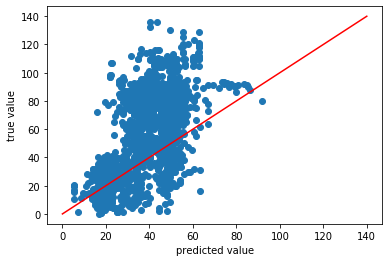

In [28]:
plt.scatter(np.exp(X[0].mv(res.all_final_model[0])), np.exp(Y[0]))
plt.plot(np.linspace(0, 140, 50), np.linspace(0, 140, 50), color='r')
plt.xlabel("predicted value")
plt.ylabel("true value")

In [15]:
res.all_final_model[0]

tensor([ 33.9411,  -6.3146,  10.3740,  -6.4186,  -2.0952,  -0.2281, -13.5557,
          3.6145,  11.0917,   0.5331,  -5.9883,  -4.8490,   3.0590,   2.9579,
         -1.6102,  -1.1113,   2.8860,   9.8454,  19.4236,   3.6078, -14.6197,
         -5.5853,   9.9414,  20.2666, -17.5310, -12.7006,  -0.8226,  10.7726,
         16.9628,  -3.4666, -22.9090,  10.0717, -11.2796,  -2.9213,   1.8783,
         10.3147,   4.7704,  -6.2638,  -7.1845,   0.4165,  10.0032,  -3.0735,
         -2.3684,  17.2126,   4.8062, -18.5534,   0.5732,  -5.5403, -20.6466,
         -4.3225,  25.0669,  -9.7612,   5.2041,  -4.8136,  -4.0375,   2.0869,
         -3.8614,   8.3663,  -7.4274,   4.3532,   3.7160,  -1.7543,  -0.1988,
         20.3631,  -3.6228,  -9.0093,   1.6601,   2.8825, -11.6595,  -8.3061,
          9.2813,   5.6261,  -2.1384,  -0.6271,   4.7997,  -3.8837,  11.6666,
        -16.9688,   6.0668,   2.3140,  -0.0832,  -7.8229], dtype=torch.float64)

## With averaging

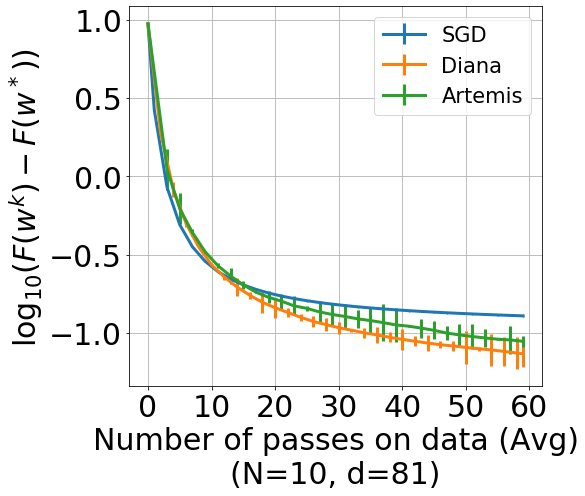

In [32]:
(X,Y) = pickle_loader(filename + "-data")
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), x_legend="Number of passes on data (Avg)") 

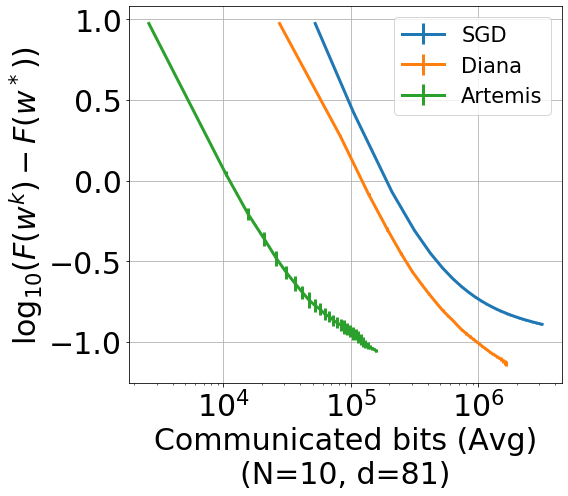

In [33]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


## Without averaging

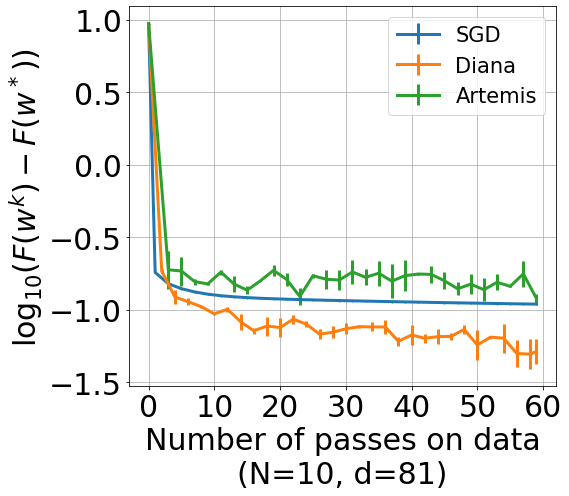

In [34]:
(X,Y) = pickle_loader(filename + "-data")
myX = X[:nb_devices_for_the_run]
myY = Y[:nb_devices_for_the_run]
obj_min_by_N = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")
obj = obj_min_by_N[len(myX)]

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 

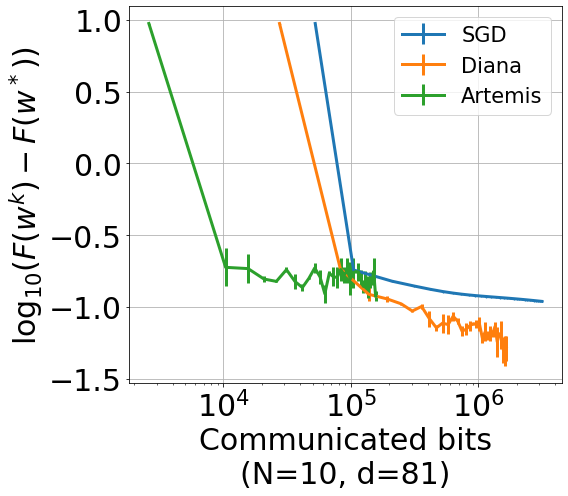

In [35]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 